# Depression Self Test

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

import logging

from gensim.models import word2vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HAPPY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stop_words = set(stopwords.words("english"))
tokenizer = TweetTokenizer()
stemmer = SnowballStemmer('english')

---
# 1. 데이터 불러오기

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


---
# 2. EDA & Feature Engineering

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22430,3
top,df398a774e,Roscoe - Smooth Sailin` WHY DID NO ONE TELL ME...,good,neutral
freq,1,1,199,11117


## - 결측치 유무 확인

In [7]:
# 결측치 유무 확인
train.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

## - 라벨 분포도

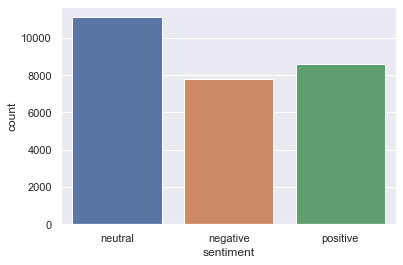

In [8]:
sns.countplot(x="sentiment", data=train)
plt.show()

---
# 3. 데이터셋 구성

## - 데이터 전처리

In [9]:
# 텍스트 전처리 함수
def preprocessing(train, tokenizer, remove_stopwords=False):
    
    # 모두 소문자로 변환
    lower_type = train.lower()
    
    # 개행 제거
    n_drop = re.sub('\\n', " ", lower_type)
    
    # 특문 제거
    parse = re.sub(r'[^a-zA-Z ]', ' ', n_drop)
    
    # 토큰화
    words = tokenizer.tokenize(parse)
        
    # 불용어 제거
    if remove_stopwords:
        words = [w for w in words if not w in stop_words]

    # 어간 추출
    word_lem = [stemmer.stem(w) for w in words]

    
    return(word_lem)

### train set 전처리

In [10]:
# 라벨(sentiment) 수치화
for i in range(0,train['text'].count()+1):
    try:
        if train['sentiment'][i] == "neutral":
            train['sentiment'][i] = -1
                
        elif train['sentiment'][i] == "negative":
            train['sentiment'][i] = 1
            
        elif train['sentiment'][i] == "positive":
            train['sentiment'][i] = 0

            
        else:
            i += 1
            
    except KeyError:
        i += 1

In [11]:
# 데이터중 textID와 selected_text는 불필요하므로 제거
train_data = train[['text','sentiment']]

# 라벨(sentiment) 중 neutral(중립)인 것은 불필요하므로 제거
train_data.loc[train_data['sentiment'] == -1, 'sentiment'] = np.nan
train_data = train_data.dropna(how = 'any')

# 제거 후 index 재정렬
train_data = train_data.reset_index(drop = True)
train_data

,text,sentiment
0,Sooo SAD I will miss you here in San Diego!!!,1
1,my boss is bullying me...,1
2,what interview! leave me alone,1
3,"Sons of ****, why couldn`t they put them on t...",1
4,2am feedings for the baby are fun when he is a...,0
...,...,...
16358,enjoy ur night,0
16359,wish we could come see u on Denver husband l...,1
16360,I`ve wondered about rake to. The client has ...,1
16361,Yay good for both of you. Enjoy the break - y...,0


### test set 전처리 (train set과 동일)

In [12]:
for i in range(0,test['text'].count()+1):
    try:
        if test['sentiment'][i] == "neutral":
            test['sentiment'][i] = -1
            
        elif test['sentiment'][i] == "negative":
            test['sentiment'][i] = 1
            
        elif test['sentiment'][i] == "positive":
            test['sentiment'][i] = 0        
            
        else:
            i += 1
            
    except KeyError:
        i += 1

In [13]:
test_data = test[['text','sentiment']]
test_data.loc[test_data['sentiment'] == -1, 'sentiment'] = np.nan
test_data = test_data.dropna(how = 'any')
test_data = test_data.reset_index(drop = True)
test_data

,text,sentiment
0,Shanghai is also really exciting (precisely -...,0
1,"Recession hit Veronique Branquinho, she has to...",1
2,happy bday!,0
3,http://twitpic.com/4w75p - I like it!!,0
4,that`s great!! weee!! visitors!,0
...,...,...
2099,"its at 3 am, im very tired but i can`t sleep ...",1
2100,All alone in this old house again. Thanks for...,0
2101,I know what you mean. My little dog is sinkin...,1
2102,_sutra what is your next youtube video gonna b...,0


## - Word2Vec을 이용한 워드 임베딩

In [14]:
# Word2Vec 훈련에 이용할 데이터 생성
sentences=[]

for i in range(0,train_data['text'].count()+1):
    try:
        sentences.append(preprocessing(train_data['text'][i], tokenizer, remove_stopwords=False))
    except KeyError:
        i += 1

In [15]:
# W2V 학습시 출력메세지 생성하도록
# 기본 로깅 모듈 구성
logging.basicConfig(format = '%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

In [16]:
num_features = 300         # 단어 벡터차원 수 (많을 수록 시간 오래 걸리고 좋아짐)
min_word_count = 40          # 최소 문자 수 (10~100 사이 추천)
num_workers = 4          # 병렬로 실행할 thread 수
context = 10          #문자열 창 크기
downsampling = 1e-3          #문자 빈도 수에대한 downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window = context,
                          sample = downsampling)
model

2020-07-21 04:21:44,620:INFO:collecting all words and their counts
2020-07-21 04:21:44,620:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-21 04:21:44,669:INFO:PROGRESS: at sentence #10000, processed 136981 words, keeping 10713 word types
2020-07-21 04:21:44,722:INFO:collected 14228 word types from a corpus of 223552 raw words and 16363 sentences
2020-07-21 04:21:44,724:INFO:Loading a fresh vocabulary
2020-07-21 04:21:44,738:INFO:effective_min_count=40 retains 632 unique words (4% of original 14228, drops 13596)
2020-07-21 04:21:44,739:INFO:effective_min_count=40 leaves 179773 word corpus (80% of original 223552, drops 43779)
2020-07-21 04:21:44,743:INFO:deleting the raw counts dictionary of 14228 items
2020-07-21 04:21:44,745:INFO:sample=0.001 downsamples 79 most-common words
2020-07-21 04:21:44,745:INFO:downsampling leaves estimated 119392 word corpus (66.4% of prior 179773)
2020-07-21 04:21:44,749:INFO:estimated required memory for 632 words and 300 di

In [17]:
# 학습 완료면 필요없는 메모리 unload
model.init_sims(replace=True)

# 모델 save
model_name = '300feautres_40minwords_10text'
model.save(model_name)

2020-07-21 04:21:46,191:INFO:precomputing L2-norms of word weight vectors
2020-07-21 04:21:46,195:INFO:saving Word2Vec object under 300feautres_40minwords_10text, separately None
2020-07-21 04:21:46,197:INFO:not storing attribute vectors_norm
2020-07-21 04:21:46,199:INFO:not storing attribute cum_table
2020-07-21 04:21:46,223:INFO:saved 300feautres_40minwords_10text


In [18]:
# 모델 결과 탐색
# 가장 유사도 없는 단어 확인가능
model.wv.doesnt_match('he she i car'.split())

'i'

In [19]:
# 가장 유사한 단어 확인가능
model.wv.most_similar('car')

[('left', 0.9927546977996826),
 ('walk', 0.9925647974014282),
 ('class', 0.9923371076583862),
 ('full', 0.9922627210617065),
 ('end', 0.9906659126281738),
 ('room', 0.9902822971343994),
 ('took', 0.9889705777168274),
 ('woke', 0.9883118867874146),
 ('summer', 0.988208532333374),
 ('sinc', 0.9882078766822815)]

In [20]:
# 단어 벡터의 평균 구함
# list의 각 칸 넘어옴

def makeFeatureVec(words, model, num_features):
    # 0으로 채운 배열로 초기화함(빠르게 하려고)
    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0.
    
    # 단어명 담은 리스트
    index2word_set = set(model.wv.index2word)
    
    # 사전에 포함된 단어만 피처에 추가
    # 리스트 각칸의 한 단어별로
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
            
    # 결과를 단어수로 나눠 평균 구함        
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [21]:
# 리뷰 단어 목록의 각각 평균 feature 벡터 계산, 2D numpy 배열 반환
# 정제된 list 넘어옴 = review

def getAvgFeatureVecs(reviews, model, num_features):
    # counter 초기화
    counter = 0.
    
    # 0으로 채운 2D numpy 배열로 할당
    reviewFeatureVecs = np.zeros((len(reviews),num_features), dtype="float32")
    
    for review in reviews:
        # 평균 피처 벡터만드는 함수 호출
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)
        
        #counter 증가시킴
        counter = counter + 1
        
    return reviewFeatureVecs

In [22]:
# 텍스트 정제하는 함수
def getCleanTexts(train):
    clean_texts = []
    for text in train['text']:
        clean_texts.append(preprocessing(text, tokenizer, remove_stopwords=True))
        
    return clean_texts

### 텍스트 벡터화

In [23]:
%time trainDataVecs = getAvgFeatureVecs(getCleanTexts(train_data), model, num_features)

Wall time: 10.7 s


In [24]:
%time testDataVecs = getAvgFeatureVecs(getCleanTexts(test_data), model, num_features)

Wall time: 1.52 s


### 훈련, 검증, 테스트 데이터 분리

In [25]:
from sklearn.model_selection import train_test_split

X_features = trainDataVecs
y_labels = train_data['sentiment'].astype('int')

X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_labels, test_size=0.2, random_state=2020)

X_test = testDataVecs
y_test = test_data['sentiment'].astype('int')

### 훈련 데이터 결측치 처리

In [26]:
# X_train에 결측치 유무 확인
np.argwhere(np.isnan(X_train))

array([[   28,     0],
       [   28,     1],
       [   28,     2],
       ...,
       [12951,   297],
       [12951,   298],
       [12951,   299]], dtype=int64)

In [27]:
# X_train의 결측치 평균으로 대치
X_train = np.nan_to_num(X_train)
X_train[np.isnan(X_train)] = np.mean(X_train)
X_train

array([[ 0.01675979,  0.02250945,  0.01868851, ..., -0.02713728,
         0.04263344,  0.0250473 ],
       [ 0.00384419,  0.10357732, -0.00674484, ...,  0.08919662,
         0.0189111 ,  0.04260093],
       [ 0.01157504,  0.06630652,  0.0057553 , ...,  0.10135307,
         0.00713612,  0.05337464],
       ...,
       [ 0.00784472,  0.07791059,  0.00309383, ...,  0.05106642,
         0.03233997,  0.04278511],
       [-0.00472401,  0.11694765, -0.01024401, ...,  0.10957284,
         0.01706355,  0.04593765],
       [-0.01839467,  0.11667078, -0.00915575, ...,  0.11205899,
         0.01320203,  0.03634506]], dtype=float32)

### 검증 데이터 결측치 처리 (훈련 데이터와 동일)

In [28]:
np.argwhere(np.isnan(X_valid))

array([[  16,    0],
       [  16,    1],
       [  16,    2],
       ...,
       [3272,  297],
       [3272,  298],
       [3272,  299]], dtype=int64)

In [29]:
X_valid = np.nan_to_num(X_valid)
X_valid[np.isnan(X_valid)] = np.mean(X_valid)
X_valid

array([[-0.01926955,  0.13488826, -0.02296158, ...,  0.1046252 ,
         0.00906781,  0.03182385],
       [-0.00218758,  0.10204604, -0.01202081, ...,  0.035837  ,
         0.03422397,  0.02505171],
       [-0.03118591,  0.13910522, -0.0379652 , ...,  0.11315769,
        -0.00280335,  0.01026772],
       ...,
       [-0.01228986,  0.11895913, -0.01520921, ...,  0.13805091,
        -0.00360509,  0.04366026],
       [-0.00623794,  0.08685693,  0.00296267, ...,  0.02865428,
         0.04776416,  0.02973313],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

### 테스트 데이터 결측치 처리  (훈련 데이터와 동일)

In [30]:
np.argwhere(np.isnan(X_test))

array([[  12,    0],
       [  12,    1],
       [  12,    2],
       ...,
       [2094,  297],
       [2094,  298],
       [2094,  299]], dtype=int64)

In [31]:
X_test = np.nan_to_num(X_test)
X_test[np.isnan(X_test)] = np.mean(X_test)
X_test

array([[-0.00203001,  0.09485388, -0.01587339, ...,  0.08020368,
         0.0201322 ,  0.03676275],
       [-0.00185658,  0.11282672, -0.01348725, ...,  0.11570454,
         0.01029878,  0.04693563],
       [ 0.02386784, -0.00896012,  0.02266305, ..., -0.05748982,
         0.03855301,  0.020691  ],
       ...,
       [-0.01412031,  0.1246073 , -0.03028169, ...,  0.12250342,
        -0.00595896,  0.03120884],
       [ 0.000312  ,  0.08710513,  0.00378743, ...,  0.09968013,
         0.01243629,  0.04775744],
       [ 0.04139678, -0.0438943 ,  0.05319297, ...,  0.13420956,
        -0.0259742 ,  0.08962701]], dtype=float32)

---
# 4. 모델링 및 학습

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=2018)

In [34]:
%time forest = forest.fit(X_train, y_train)

Wall time: 27.5 s


---
# 5. 모델 검증 및 예측

In [35]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(forest, X_valid, y_valid, cv=10, scoring='roc_auc'))

print(score)

Wall time: 49.6 s
0.8482538234648631


In [36]:
result = forest.predict(X_test)

In [37]:
comparison = pd.DataFrame(y_test)
comparison['my_predict'] = result
comparison.head(10)

,sentiment,my_predict
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
5,1,0
6,1,1
7,1,1
8,1,1
9,1,1


In [38]:
evaluation = (comparison['sentiment'] == comparison['my_predict'])

success = (evaluation == True).sum()
failure = (evaluation == False).sum()

print(success / (success + failure))

0.7980038022813688


In [39]:
from sklearn.metrics import accuracy_score

pred = forest.predict(X_test)
print('정확도:{0:.4f}'.format(accuracy_score(y_test, pred)))

정확도:0.7980


---
# 6. 우울감 정도 구하기

In [115]:
# 우울감 정도 구하는 함수
def depress_analysis(text):
    pos_words = pd.read_csv("positive_words.csv").positive_list.tolist()
    neg_words = pd.read_csv("negative_words.csv").negative_list.tolist()
    depr_words = pd.read_csv('depress_words.csv').depress_list.tolist()
    
    text = " ".join(preprocessing(text, tokenizer, remove_stopwords=True))
    
    count_of_word = len(text.split())
    
    # 우울 단어 세기
    depr = sum((1 for word in depr_words if text.count(word)>0)) * 3
    
    # 부정 단어 세기
    neg = sum((1 for word in neg_words if text.count(word)>0)) * 2 + depr
    
    # 긍정 단어 세기
    pos = sum((1 for word in pos_words if text.count(word)>0))
    
    # 중립 단어 세기
    neu = count_of_word - (neg + pos)
    
    # 중립 단어 개수 빼기
    count_of_word = count_of_word - neu
    
    try:
        # 긍정비율
        pos_ratio = pos / (pos + neg)

        # 부정비율
        neg_ratio = neg / (pos + neg)
    except ZeroDivisionError:
        pos_ratio = 0
        neg_ratio = 0
        
    final_score = pos_ratio - neg_ratio
    
    return getAvgFeatureVecs([text], model, num_features), final_score

In [56]:
# 테스트 데이터 적용 예시
test_data['depr_amount'] = test_data['text'].apply(lambda x : depress_analysis(x)[1])
test_data.head(10)

,text,sentiment,depr_amount
0,Shanghai is also really exciting (precisely -...,0,0.636364
1,"Recession hit Veronique Branquinho, she has to...",1,-0.500000
2,happy bday!,0,1.000000
3,http://twitpic.com/4w75p - I like it!!,0,0.428571
4,that`s great!! weee!! visitors!,0,1.000000
5,I THINK EVERYONE HATES ME ON HERE lol,1,-0.200000
6,"soooooo wish i could, but im in school and my...",1,-0.111111
7,My bike was put on hold...should have known th...,1,-0.411765
8,"I`m in VA for the weekend, my youngest son tur...",1,-0.454545
9,Its coming out the socket I feel like my phon...,1,0.076923


---
# 최종 결과 예시

In [116]:
diary = "today, i have been to a hospital to see a doctor.\
i had a fever and coughed severely. and i had a runny nose.\
i've come down with a bad cold.\
i thought it was because i was caught in a shower yesterday.\
the doctor gave me the prescription to take the medicine in the drug store.\
i was supposed to take three pills three times a day after each meal.\
i felt so sleepy after taking the medicine.\
i thought it was a common side effect.\
i wanted to lie down and relax.\
i want to go to bed early. today, i didn't my homework.\
tomorrow morning, i will do it.\
i had a terrible headache.\
i realize health is more important than any other thing.\
to be more healthy, i have to exercise regularly.\
even though i have not much time to exercise, i'll try to start by doing simple exercises such as running and skipping."
result = depress_analysis(diary)
depr_check = bool(forest.predict(result[0]))
score = result[1]

if score < 0:
    score =  int(- score * 100)

if depr_check:
    print(f'당신은 {score}% 우울합니다')
else:
    print('당신은 우울하지 않습니다.')

당신은 59% 우울합니다


In [117]:
diary = "Today, it is finally the announcement date of the certification result.\
I have been looking forward to my results because I studied hard.\
If I pass, I feel like I'm going away.\
The moment I saw the result, I was happy and felt like I had everything in this world.\
I think happy days will continue for me in the future.\
With this mindset, I want to do other things harder to achieve my goals and succeed."
result = depress_analysis(diary)
depr_check = bool(forest.predict(result[0]))
score = result[1]

if score < 0:
    score =  int(- score * 100)

if depr_check:
    print(f'당신은 {score}% 우울합니다')
else:
    print('당신은 우울하지 않습니다.')

당신은 우울하지 않습니다.


In [118]:
diary = "It felt darker this evening.\
Because I just broke up with my boyfriend.\
He said that the time he spent with me was lonely.\
As soon as I heard him, I was shocked.\
For two hours he left me with hurtful words.\
The clouds were full on the way home from him.\
My heart seems to be cloudy.\
I cried when I came home and saw the pictures I took with him.\
My mood became gloomy and grey.\
When the man I love left, I felt like a pitiful woman.\
What should I do from now on?"
result = depress_analysis(diary)
depr_check = bool(forest.predict(result[0]))
score = result[1]

if score < 0:
    score =  int(- score * 100)

if depr_check:
    print(f'당신은 {score}% 우울합니다')
else:
    print('당신은 우울하지 않습니다.')

당신은 47% 우울합니다
